In [2]:
10*(0.7**3)*(0.3**2) + 5*(0.7**4)*(0.3**1) + (0.7**5)*(0.3**0)

0.8369199999999998

In [3]:
# Disable warnings in Anaconda
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [4]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 11, 8

In [5]:
def fill_nan(table):
    for col in table.columns:
        table[col] = table[col].fillna(table[col].median())
    return table 

In [7]:
data = pd.read_csv('../Datasets/credit_scoring_sample.csv', sep =',')
data.head()


,SeriousDlqin2yrs,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
0,0,64,0,0.249908,0,0,8158.0,0.0
1,0,58,0,3870.000000,0,0,NaN,0.0
2,0,41,0,0.456127,0,0,6666.0,0.0
3,0,43,0,0.000190,0,0,10500.0,2.0
4,1,49,0,0.271820,0,0,400.0,0.0


In [8]:
data.dtypes

SeriousDlqin2yrs                          int64
age                                       int64
NumberOfTime30-59DaysPastDueNotWorse      int64
DebtRatio                               float64
NumberOfTimes90DaysLate                   int64
NumberOfTime60-89DaysPastDueNotWorse      int64
MonthlyIncome                           float64
NumberOfDependents                      float64
dtype: object

Distribution of the target:


0    0.777511
1    0.222489
Name: SeriousDlqin2yrs, dtype: float64

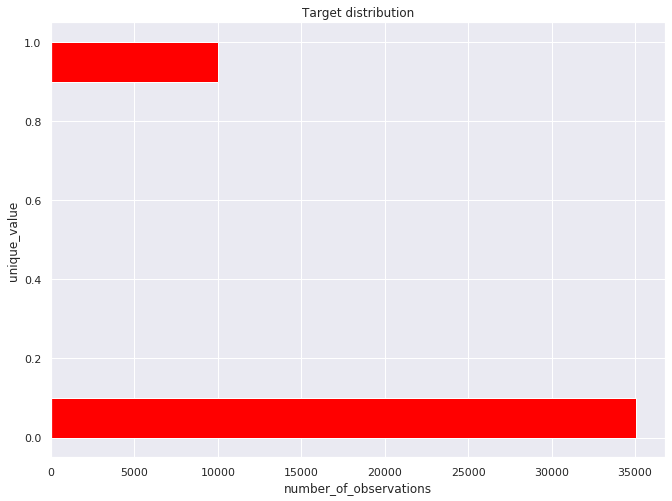

In [9]:
ax = data['SeriousDlqin2yrs'].hist(orientation='horizontal', color='red')
ax.set_xlabel("number_of_observations")
ax.set_ylabel("unique_value")
ax.set_title("Target distribution")

print('Distribution of the target:')
data['SeriousDlqin2yrs'].value_counts()/data.shape[0]


In [10]:
independent_columns_names = [x for x in data if x != 'SeriousDlqin2yrs']
independent_columns_names

['age',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'DebtRatio',
 'NumberOfTimes90DaysLate',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'MonthlyIncome',
 'NumberOfDependents']

In [11]:
table = fill_nan(data)

In [51]:
X = table[independent_columns_names]
y = table['SeriousDlqin2yrs']

In [23]:
def stat_intervals(stat, alpha):
    # функция для интервальной оценки
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

def get_bootstrap_samples(data, n_samples):
    # функция для генерации подвыборок с помощью бутстрэпа
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

idiots = data[data['SeriousDlqin2yrs'] == 1]['age'].values

np.random.seed(0)

idiots_mean_scores = [np.mean(sample) for sample in get_bootstrap_samples(idiots, 1000)]

print('mean interval for age of idiots: {}'.format(stat_intervals(idiots_mean_scores,0.1)))

mean interval for age of idiots: [45.71379414 46.12700479]


In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold

In [25]:
lr = LogisticRegression(random_state=5, class_weight='balanced')

In [26]:
parameters = {'C': (0.0001, 0.001, 0.01, 0.1, 1, 10)}

In [27]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)

In [30]:
grid_search = GridSearchCV(lr, parameters, n_jobs=-1, scoring='roc_auc', cv=skf)
grid_search = grid_search.fit(X, y)
grid_search.best_estimator_

LogisticRegression(C=0.001, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=5, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [32]:
rocauc_best = grid_search.best_score_

In [38]:
grid_search.cv_results_['std_test_score']

array([0.0036604 , 0.00352789, 0.00382522, 0.00391643, 0.00378448,
       0.00410085])

In [39]:
rocauc_best

0.796206476909831

In [40]:
from sklearn.preprocessing import StandardScaler
scal = StandardScaler()
lr = LogisticRegression(C=0.001,random_state=5,class_weight='balanced')
lr.fit(scal.fit_transform(X),y)

pd.DataFrame({'feat': independent_columns_names,
              'coef': lr.coef_.flatten().tolist()}).sort_values(by='coef', ascending=False)

,feat,coef
1,NumberOfTime30-59DaysPastDueNotWorse,0.724004
3,NumberOfTimes90DaysLate,0.517673
4,NumberOfTime60-89DaysPastDueNotWorse,0.194732
6,NumberOfDependents,0.101326
2,DebtRatio,-0.024082
5,MonthlyIncome,-0.162864
0,age,-0.416304


In [44]:
print((np.exp(lr.coef_[0]) / np.sum(np.exp(lr.coef_[0])))[2])

0.11420536719928262


In [43]:
lr.coef_[0]

array([-0.41630368,  0.72400432, -0.02408186,  0.51767292,  0.19473217,
       -0.16286353,  0.10132603])

In [49]:
X['age'] = X['age'] + 20

In [50]:
X.head()

,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
0,84,0,0.249908,0,0,8158.0,0.0
1,78,0,3870.000000,0,0,5166.0,0.0
2,61,0,0.456127,0,0,6666.0,0.0
3,63,0,0.000190,0,0,10500.0,2.0
4,69,0,0.271820,0,0,400.0,0.0


In [52]:
lr.fit(X,y)

LogisticRegression(C=0.001, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=5, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [53]:
pd.DataFrame({'feat': independent_columns_names,
              'coef': lr.coef_.flatten().tolist()}).sort_values(by='coef', ascending=False)

,feat,coef
1,NumberOfTime30-59DaysPastDueNotWorse,0.482349
3,NumberOfTimes90DaysLate,0.430314
6,NumberOfDependents,0.115356
4,NumberOfTime60-89DaysPastDueNotWorse,0.065958
2,DebtRatio,-0.000011
5,MonthlyIncome,-0.000011
0,age,-0.018185


In [54]:
np.exp(lr.coef_[0][0]*20)

0.6950957748214892

In [56]:
lr.coef_

array([[-1.81852819e-02,  4.82349233e-01, -1.07983115e-05,
         4.30314156e-01,  6.59578704e-02, -1.14476586e-05,
         1.15356249e-01]])

In [57]:
from sklearn.ensemble import RandomForestClassifier

In [58]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42, 
                            class_weight='balanced')


In [59]:
parameters = {'max_features': [1, 2, 4], 'min_samples_leaf': [3, 5, 7, 9], 'max_depth': [5,10,15]}

In [61]:
grid_search = GridSearchCV(rf, parameters, n_jobs=-1, scoring='roc_auc', cv=skf)
grid_search = grid_search.fit(X, y)
print(grid_search.best_score_ - rocauc_best)

0.03942497130140299


In [63]:
independent_columns_names[np.argmin(grid_search.best_estimator_.feature_importances_)]

'NumberOfDependents'

In [64]:
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_val_score, RandomizedSearchCV

parameters = {'max_features': [2, 3, 4], 'max_samples': [0.5, 0.7, 0.9], 
              'base_estimator__C': [0.0001, 0.001, 0.01, 1, 10, 100]}

In [66]:
bc = BaggingClassifier(base_estimator=LogisticRegression(class_weight='balanced'),random_state=42,n_estimators=100)
RSCV = RandomizedSearchCV(bc,parameters,n_jobs=-1,scoring='roc_auc',cv=skf,random_state=1,n_iter=20,verbose=True)
RSCV = RSCV.fit(X,y)
print(RSCV.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 18.9min finished


0.8074677872295736
